# Quantum Phase Estimation

# Example T-gate

Here we want to use QPE to estimate the eigenvalue of the T-gate. The T-gate is defined as:

\begin{equation}
T = \begin{pmatrix}
1 & 0 \\
0 & e^{4i \pi } 
\end{pmatrix}
\end{equation}

Since $T\left|1\right> = e^{2\pi i \theta} \left| 1 \right>$, where $\theta = \frac{1}{8}$.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import qiskit as qsk 

Here we will use 1 ancilla qubit that has the eigenstate of T and 2 qubits for the phase estimation.

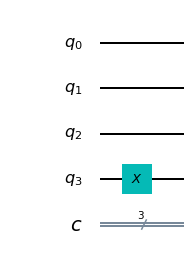

In [2]:
qpe = qsk.QuantumCircuit(4,3)
qpe.x(3) #Putting the ancilla in the eigenstate
qpe.draw('mpl')

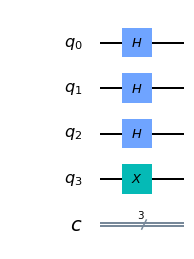

In [3]:
for qubit in range(3):
    qpe.h(qubit)
qpe.draw('mpl')

Let's apply the controlled unitary opperations.

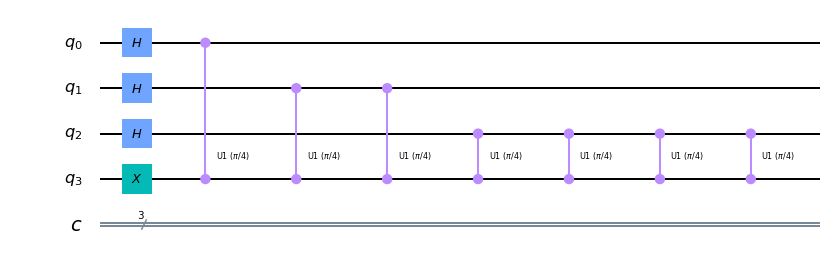

In [4]:
repetitions = 1
for counting_qubit in range(3):
    for i in range(repetitions):
        qpe.cu1(np.pi/4, counting_qubit, 3); # This is C-U
    repetitions *= 2
qpe.draw(output='mpl')

Now we apply the fourier transform for the 3 qpe qubits

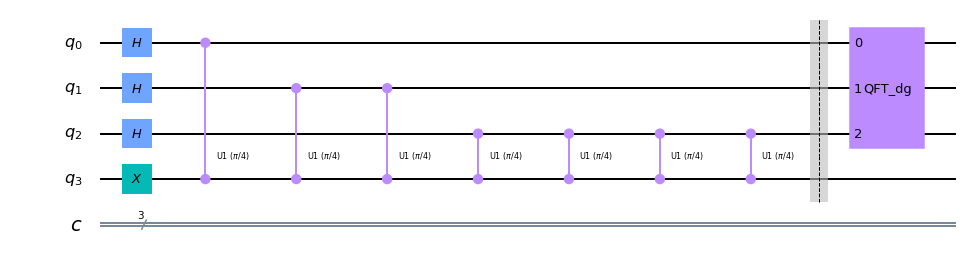

In [5]:
#Append path for Algorithms.py
import sys
sys.path.append('../')

from Algorithms import inverse_QFT
qpe.barrier()
inverse_QFT(qpe,3)
qpe.draw('mpl')

Let's measure the first 3 qubits

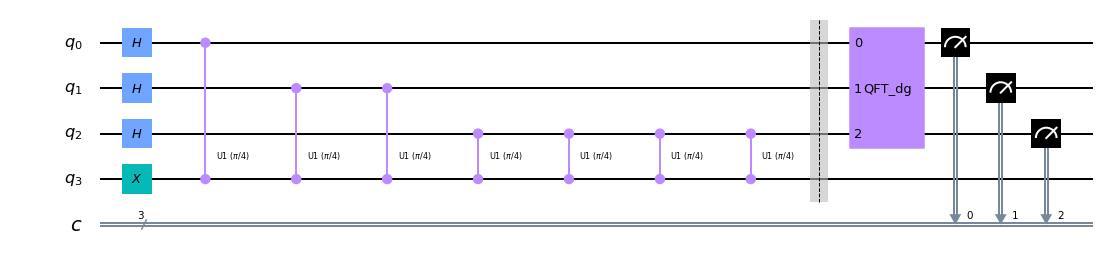

In [6]:
qpe.measure(range(3),range(3))
qpe.draw('mpl')

## Simulations 

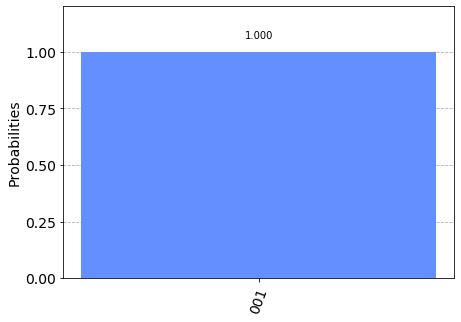

In [7]:
from qiskit.visualization import plot_histogram

backend = qsk.Aer.get_backend('qasm_simulator')
shots = 2048
results = qsk.execute(qpe, backend=backend, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

In [8]:
def conv2float(ans):
    fl=0
    for i,val in enumerate(ans):
        if val == '1':
            fl += 2**(-i-1)
    return fl
    
ans = max(answer, key=answer.get)
print(f'answer binary: {ans}')
print(f'answer float: {conv2float(ans)}')

answer binary: 001
answer float: 0.125


Therefore we have the result being: $\left| 001 \right>$, then: $0*2^{-1} + 0*2^{-2} + 1*2^{-3} = 0.125$ that is near our desired result:  $\theta =\frac{1}{8} = 0.125$

# T-Gate without the eigenvector on the ancilla

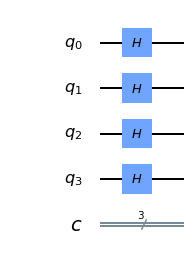

In [9]:
qpe = qsk.QuantumCircuit(4,3)
qpe.h(3) #Putting the ancilla in the eigenstate
qpe.h(range(3))
qpe.draw('mpl')

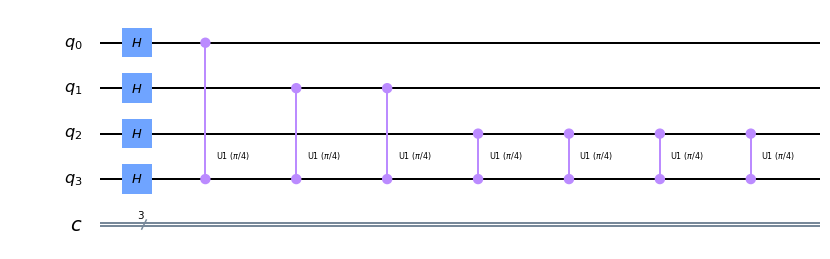

In [10]:
repetitions = 1
for counting_qubit in range(3):
    for _ in range(repetitions):
        qpe.cu1(np.pi/4, counting_qubit, 3); # This is C-U
    repetitions *= 2
qpe.draw(output='mpl')

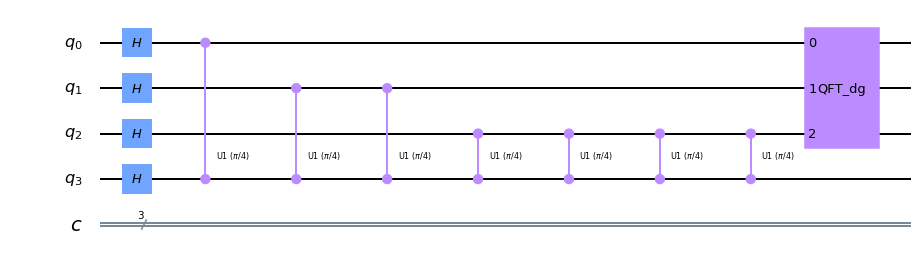

In [11]:
from Algorithms import inverse_QFT
inverse_QFT(qpe,3)
qpe.draw('mpl')

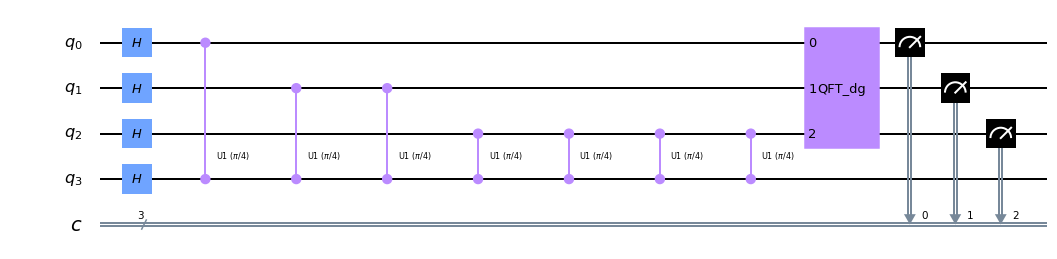

In [12]:
qpe.measure(range(3),range(3))
qpe.draw('mpl')

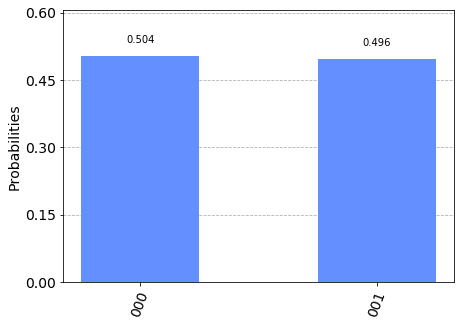

In [13]:
from qiskit.visualization import plot_histogram

backend = qsk.Aer.get_backend('qasm_simulator')
shots = 2048
results = qsk.execute(qpe, backend=backend, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

Thus you have both solutions for the eigenvalues with equal probability: 0 and 0.125!

# Making the general algorithm

In the general algorithm we want to do the quantum phase estimation on a arbitrary unitary U.

In [14]:
#Append path for Algorithms.py
import sys
sys.path.append('../')


from qiskit.circuit.add_control import add_control
from Algorithms import inverse_QFT

def qpe(circuit, unitary, n_precision,n_ancilla):   
    """Applies the quantum phase estimation for a given unitary.

    Parameters
    ------------------------------------------------
    circuit(qiskit.QuantumCircuit): Quantum Circuit.
    unitary(np.array): Unitary.
    n_precision(int): Number of qubits used for precision.
    n_ancilla(int): Number of qubits used for generating the eigenstates, 
                    must be len(unitary)//2 = n_ancilla.

    Output
    ------------------------------------------------
    circuit(qiskit.QuantumCircuit): Quantum Circuit with
                                    qft.
    
    """
    assert len(unitary)//2 == n_ancilla, "Ancilla qubits does't match the number needed to expand the eigenstate."    
    #Ancilla (need to add a way to initialize states)
    circuit.h([n_precision + ancilla for ancilla in range(n_ancilla)]) 
    #Precision
    circuit.h(range(n_precision))
    #Build unitary
    U = qsk.extensions.UnitaryGate(unitary, label='U')
    U_ctrl = add_control(U, num_ctrl_qubits=1, label='Controlled_U',ctrl_state=1)    
    repetitions = 1
    for counting_qubit in range(n_precision):
        for _ in range(repetitions):                        
            circuit.append(U_ctrl, [counting_qubit,*[n_precision + ancilla for ancilla in range(n_ancilla)]])         
        repetitions *= 2
    inverse_QFT(circuit,n_precision)    
    return qpe

In [15]:
T = [[1.,0.],[0.,np.exp(-1.j*np.pi/4.)]]
n_ancilla = 1
n_precision = 3
qc = qsk.QuantumCircuit(n_precision+n_ancilla, n_precision)
qpe(qc, T, n_precision, n_ancilla)
qc.measure(range(n_precision), range(n_precision))
qc.draw()

┌───┐┌───────────────┐                                                   »
q_0: ┤ H ├┤0              ├───────────────────────────────────────────────────»
     ├───┤│               │┌───────────────┐┌───────────────┐                 »
q_1: ┤ H ├┤               ├┤0              ├┤0              ├─────────────────»
     ├───┤│  Controlled_U ││               ││               │┌───────────────┐»
q_2: ┤ H ├┤               ├┤  Controlled_U ├┤  Controlled_U ├┤0              ├»
     ├───┤│               ││               ││               ││  Controlled_U │»
q_3: ┤ H ├┤1              ├┤1              ├┤1              ├┤1              ├»
     └───┘└───────────────┘└───────────────┘└───────────────┘└───────────────┘»
c_0: ═════════════════════════════════════════════════════════════════════════»
                                                                              »
c_1: ═════════════════════════════════════════════════════════════════════════»
                                                                              »
c_2: ═════════════════════════════════════════════════════════════════════════»
                                                                              »
«                                                        ┌─────────┐┌─┐      
«q_0: ───────────────────────────────────────────────────┤0        ├┤M├──────
«                                                        │         │└╥┘┌─┐   
«q_1: ───────────────────────────────────────────────────┤1 QFT_dg ├─╫─┤M├───
«     ┌───────────────┐┌───────────────┐┌───────────────┐│         │ ║ └╥┘┌─┐
«q_2: ┤0              ├┤0              ├┤0              ├┤2        ├─╫──╫─┤M├
«     │  Controlled_U ││  Controlled_U ││  Controlled_U │└─────────┘ ║  ║ └╥┘
«q_3: ┤1              ├┤1              ├┤1              ├────────────╫──╫──╫─
«     └───────────────┘└───────────────┘└───────────────┘            ║  ║  ║ 
«c_0: ═══════════════════════════════════════════════════════════════╩══╬══╬═
«                                                                       ║  ║ 
«c_1: ══════════════════════════════════════════════════════════════════╩══╬═
«                                                                          ║ 
«c_2: ═════════════════════════════════════════════════════════════════════╩═
«

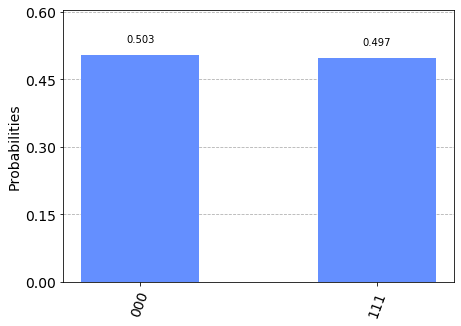

In [16]:
backend_sim = qsk.Aer.get_backend('qasm_simulator')
job_sim = qsk.execute(qc, backend_sim, shots=1024)
result_sim = job_sim.result()
counts = result_sim.get_counts(qc)

from qiskit.visualization import plot_histogram
plot_histogram(counts)

For a more elegant circuit we have the method `QPE` on Algorithms.py that gives the same result.

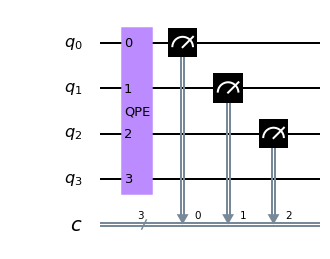

In [17]:
from Algorithms import QPE
T = [[1.,0.],[0.,np.exp(-1.j*np.pi/4.)]]
n_ancilla = 1
n_precision = 3
qc = qsk.QuantumCircuit(n_precision+n_ancilla, n_precision)
QPE(qc, T, n_precision, n_ancilla)
qc.measure(range(n_precision), range(n_precision))
qc.draw('mpl')

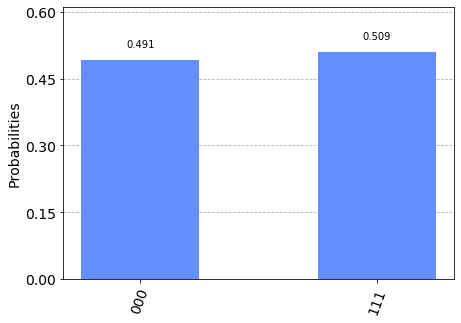

In [18]:
backend_sim = qsk.Aer.get_backend('qasm_simulator')
job_sim = qsk.execute(qc, backend_sim, shots=1024)
result_sim = job_sim.result()
counts = result_sim.get_counts(qc)

from qiskit.visualization import plot_histogram
plot_histogram(counts)

----------------------------------------------------------------------------------------------------

In [19]:
import qiskit.tools.jupyter
%qiskit_version_table